# Learn the globally optimal proposal for a linear gaussian state space model

We reproduce the experiment in Naesseth and al. Variational SMC

In [1]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pykalman
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2

seaborn.set()


In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries

from filterflow.observation.linear import LinearObservationModel

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.base import ProposalModelBase

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver, NaiveSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

### Set up the model

In [4]:
tf.random.set_seed(0)
rndstate = np.random.RandomState(0)

T = 25

d_x = 10
d_y = 10

alpha = 0.42
gamma = 0.1

B = 4
N = 4

transition_matrix = np.array([[alpha**(abs(i-j) + 1) for j in range(d_x)] for i in range(d_x)], dtype=np.float32)
transition_covariance = np.eye(d_x, dtype=np.float32)


observation_covariance = gamma * np.eye(d_y, dtype=np.float32)
observation_matrix = np.zeros([d_y, d_x], dtype=np.float32)
observation_matrix[:d_y, :d_y] = np.eye(d_y, dtype=np.float32)
# observation_matrix = np.ones([d_y, d_x], dtype=np.float32)
# observation_matrix = np.random.normal(0., 1., [d_y, d_x]).astype(np.float32)


initial_state_mean = np.zeros(d_x, dtype=np.float32)
initial_state_covariance = np.eye(d_x, dtype=np.float32)

kf = pykalman.KalmanFilter(transition_matrix, observation_matrix, transition_covariance, observation_covariance, initial_state_mean=initial_state_mean, initial_state_covariance=initial_state_covariance)
observations = kf.sample(T, random_state=rndstate)[1].data.astype(np.float32)

true_log_likelihood = kf.loglikelihood(observations)
true_log_likelihood

-383.28591316387576

In [5]:
observations_dataset = tf.data.Dataset.from_tensor_slices(observations)

### Set up the filterflow filter

In [6]:
transition_noise = tfd.MultivariateNormalDiag(tf.zeros(d_x, dtype=tf.float32), tf.linalg.diag_part(transition_covariance) ** 0.5) # mind it MultivariateNormalDiag does diag * diag...
transition_model = RandomWalkModel(tf.convert_to_tensor(transition_matrix), transition_noise)

In [7]:
observation_error = tfd.MultivariateNormalDiag(tf.zeros(d_y, dtype=tf.float32), tf.linalg.diag_part(observation_covariance) ** 0.5) # mind it MultivariateNormalDiag does diag * diag...
observation_model = LinearObservationModel(tf.convert_to_tensor(observation_matrix), observation_error)

In [8]:
class LearnableProposalModel(ProposalModelBase):
    def __init__(self, transition_matrix, name='LearnableProposalModel'):
        super(LearnableProposalModel, self).__init__(name=name)
        self._transition_matrix = transition_matrix
        self._standard_noise = tfd.MultivariateNormalDiag(tf.zeros(transition_matrix.shape[0]), tf.ones(transition_matrix.shape[0]))
    
    def propose(self, state: State, inputs, _observation: tf.Tensor):
        """See base class"""
        mu_t, beta_t, sigma_t = inputs
        
        transition_matrix = tf.linalg.matmul(tf.linalg.diag(beta_t), self._transition_matrix)
        
        pushed_particles = tf.reshape(mu_t, [1, 1, -1]) + tf.linalg.matvec(transition_matrix, state.particles)
        
        scale = tfp.bijectors.ScaleMatvecDiag(sigma_t)
        scaled_rv = tfd.TransformedDistribution(self._standard_noise, bijector=scale)        
        proposed_particles = pushed_particles + scaled_rv.sample([state.batch_size, state.n_particles])
        return attr.evolve(state, particles=proposed_particles)

    def loglikelihood(self, proposed_state: State, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        """Interface method for particle proposal
        :param proposed_state: State
            proposed state
        :param state: State
            previous particle filter state
        :param inputs: tf.Tensor
            Control variables (time elapsed, some environment variables, etc)
        :param observation: tf.Tensor
            Look ahead observation for adapted particle proposal
        :return: proposed State
        :rtype: tf.Tensor
        """            
        mu_t, beta_t, sigma_t = inputs
        transition_matrix = tf.linalg.matmul(tf.linalg.diag(beta_t), self._transition_matrix)
        pushed_particles = tf.reshape(mu_t, [1, 1, -1]) + tf.linalg.matvec(transition_matrix, state.particles)
        
        scale = tfp.bijectors.ScaleMatvecDiag(sigma_t)
        scaled_rv = tfd.TransformedDistribution(self._standard_noise, bijector=scale)
        
        diff = (pushed_particles - proposed_state.particles)
        return scaled_rv.log_prob(diff)

In [9]:
proposal_model = LearnableProposalModel(transition_matrix)
bootstrap_proposal = BootstrapProposalModel(transition_model)

In [10]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
resampling_method = MultinomialResampler()

epsilon = tf.constant(0.5)
scaling = tf.constant(0.75)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-1)

solver = PetkovSolver(tf.constant(30))
corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-1, ricatti_solver=solver, propagate_correction_gradient=False)

    
systematic_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, resampling_method)
regularized_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)
corrected_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, corrected)
bootstrap_smc = SMC(observation_model, transition_model, bootstrap_proposal, resampling_criterion, resampling_method)

In [11]:
initial_particles = tfd.MultivariateNormalDiag(initial_state_mean, tf.linalg.diag_part(initial_state_covariance)**0.5).sample([B, N])
uniform_weights = tf.ones([B, N])
uniform_weights = uniform_weights / tf.reduce_sum(uniform_weights, 1, keepdims=True)

uniform_log_weights = tf.math.log(uniform_weights)
log_likelihoods = tf.zeros([B])
init_state = State(initial_particles, uniform_log_weights, uniform_weights, log_likelihoods, None, None)

In [12]:
large_B = 100
large_initial_particles = tfd.MultivariateNormalDiag(initial_state_mean, tf.linalg.diag_part(initial_state_covariance)**0.5).sample([large_B, N])
large_uniform_weights = tf.ones([large_B, N])
large_uniform_weights = large_uniform_weights / tf.reduce_sum(large_uniform_weights, 1, keepdims=True)

large_uniform_log_weights = tf.math.log(large_uniform_weights)
large_log_likelihoods = tf.zeros([large_B])
large_init_state = State(large_initial_particles, large_uniform_log_weights, large_uniform_weights, large_log_likelihoods, None, None)

### Create the learnable variables that will be used as inputs to the proposal

In [13]:
scale = 0.5

mu_ts_init = scale * tf.random.normal([T, d_x])
beta_ts_init = 1. + scale * tf.random.normal([T, d_x])
log_sigma_ts_init = scale * tf.random.normal([T, d_x])

mu_ts_init = tf.zeros([T, d_x])
beta_ts_init = tf.ones([T, d_x])
log_sigma_ts_init = tf.zeros([T, d_x])


mu_ts = tf.Variable(mu_ts_init, trainable=True)
beta_ts = tf.Variable(beta_ts_init, trainable=True)
log_sigma_ts = tf.Variable(log_sigma_ts_init, trainable=True)

# beta_ts = []
# sigma_ts = []
# for t in range(T):
#     mu_ts.append(tf.Variable(0., trainable=True))
#     beta_ts.append(tf.Variable(1., trainable=True))
#     sigma_ts.append(tf.Variable(gamma, trainable=True))
    


In [14]:
trainable_variables = [mu_ts, beta_ts, log_sigma_ts]

In [15]:
@tf.function
def smc_routine(smc, state, use_correction_term=False):
    iterator = iter(observations_dataset)
    for t in tf.range(T):
        mu_t = mu_ts[t]
        beta_t = beta_ts[t]
        sigma_t = tf.math.exp(log_sigma_ts[t])
        obs = iterator.get_next()
        state = smc.update(state, obs, [mu_t, beta_t, sigma_t])
        t = t + 1
    res = tf.reduce_mean(state.log_likelihoods)
    if use_correction_term:
        return res, tf.reduce_mean(state.resampling_correction)
    return res, tf.constant(0.)
    

In [16]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2)

In [17]:
@tf.function
def run_one_step(smc, use_correction_term, init_state):
    with tf.GradientTape() as tape:
        tape.watch(trainable_variables)
        real_ll, correction = smc_routine(smc, init_state, use_correction_term)
        loss = -(real_ll + correction)
    grads_loss = tape.gradient(loss, trainable_variables)
    return real_ll, grads_loss

@tf.function
def train_one_step(smc, use_correction_term):
    real_ll, grads_loss = run_one_step(smc, use_correction_term, init_state)
    optimizer.apply_gradients(zip(grads_loss, trainable_variables))
    return -real_ll, grads_loss

@tf.function
def train_niter(smc, num_steps=100, use_correction_term=False, reset=True):
    if reset:
        reset_operations = [mu_ts.assign(mu_ts_init), beta_ts.assign(beta_ts_init), log_sigma_ts.assign(log_sigma_ts_init)]
    else:
        reset_operations = []
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies(reset_operations):
        tic = tf.timestamp()
        for step in tf.range(1, num_steps+1):
            loss, grads = train_one_step(smc, use_correction_term)
            elbo, _ = run_one_step(systematic_smc, False, large_init_state)

            toc = tf.timestamp()
            max_grad = tf.reduce_max(tf.abs(grads))
            if step % (num_steps // 100) == 0:
                tf.print('Step', step, '/', num_steps, ': ms per step= ', 1000. * (toc - tic) / tf.cast(step, tf.float64), ': total time (s)= ', (toc - tic), ', loss = ', loss, ', max abs grads = ', max_grad, end='\r')
            loss_tensor_array = loss_tensor_array.write(step-1, -elbo)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc-tic)
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()

@tf.function
def train_total_time(smc, total_time, use_correction_term=False, reset=True):
    if reset:
        reset_operations = [mu_ts.assign(mu_ts_init), beta_ts.assign(beta_ts_init), log_sigma_ts.assign(log_sigma_ts_init)]
    else:
        reset_operations = []
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True, element_shape=[])
    with tf.control_dependencies(reset_operations):
        tic = tf.timestamp()
        toc = tic
        step = tf.constant(1)
        while toc - tic < total_time:
            loss, grads = train_one_step(smc, use_correction_term)
            elbo, _ = run_one_step(systematic_smc, False, large_init_state)
            max_grad = tf.reduce_max(tf.abs(grads))
            loss_tensor_array = loss_tensor_array.write(step-1, -elbo)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc-tic)
            step = step + 1

            toc = tf.timestamp()

            tf.print('Time elapsed (s): ', toc-tic, ', n_steps: ', step, ': ms per step= ', 1000. * (toc - tic) / tf.cast(step, tf.float64), end='\r')
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()


@tf.function
def run_several(smc, n_times, use_correction_term=False):
    loss_array = tf.TensorArray(dtype=tf.float32, size=n_times, dynamic_size=False, element_shape=[])
    grad_array = tf.TensorArray(dtype=tf.float32, size=n_times, dynamic_size=False)
    for i in tf.range(n_times):
        real_ll, grads_loss = run_one_step(smc, use_correction_term, init_state)
        loss_array = loss_array.write(i, real_ll)        
        grad_array = grad_array.write(i, grads_loss)
        tf.print('Step: ', i+1, '/', n_times, end='\r')
    return loss_array.stack(), grad_array.stack()

In [18]:
n_iter = 500

In [19]:
sys_ll_n_epochs, _, sys_time = train_niter(systematic_smc, tf.constant(n_iter))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [20]:
sys_ll_per_seed, sys_grad_per_seed = run_several(systematic_smc, tf.constant(50))

In [21]:
sys_final_elbo = run_one_step(systematic_smc, tf.constant(False), large_init_state)
sys_final_elbo[0]

<tf.Tensor: shape=(), dtype=float32, numpy=-393.7245>

In [22]:
sys_ll_total_time, _, _ = train_total_time(systematic_smc, tf.constant(30, dtype=tf.float64))

In [23]:
reg_ll_n_epochs, _, reg_time = train_niter(regularized_smc, tf.constant(n_iter))

In [24]:
reg_final_elbo = run_one_step(systematic_smc, tf.constant(False), large_init_state)

In [25]:
reg_final_elbo[0]

<tf.Tensor: shape=(), dtype=float32, numpy=-387.80133>

In [26]:
reg_ll_per_seed, reg_grad_per_seed = run_several(regularized_smc, tf.constant(50))

In [27]:
reg_ll_total_time, _, _ = train_total_time(regularized_smc, tf.constant(30, dtype=tf.float64))

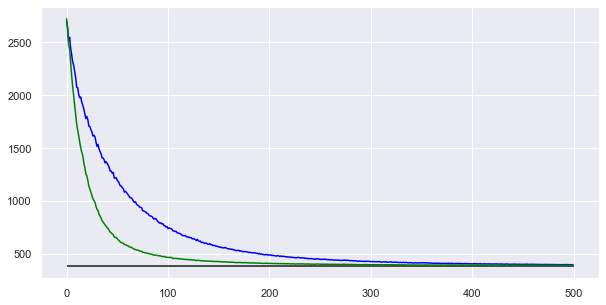

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sys_ll_n_epochs.numpy(), color='blue')
ax.plot(reg_ll_n_epochs.numpy(), color='green')
ax.hlines(-true_log_likelihood, 0, n_iter)
fig.savefig(os.path.join('./charts/', 'lgss_loss_per_epoch.png'))


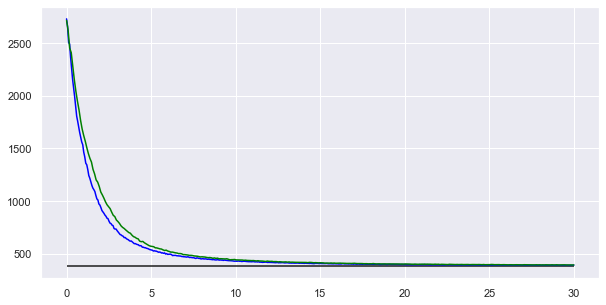

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.linspace(0, 30, len(sys_ll_total_time.numpy())), sys_ll_total_time.numpy(), color='blue')
ax.plot(np.linspace(0, 30, len(reg_ll_total_time.numpy())), reg_ll_total_time.numpy(), color='green')
ax.hlines(-true_log_likelihood, 0, 30)
fig.savefig(os.path.join('./charts/', 'lgss_loss_per_second.png'))


In [30]:
reg_loss_df = pd.Series(reg_ll_per_seed.numpy())

In [31]:
sys_loss_df = pd.Series(sys_ll_per_seed.numpy())

In [32]:
print(pd.concat([reg_loss_df, sys_loss_df], keys=['Regularized Transform', 'Multinomial Resampling'], axis=1).describe().loc[['min', 'max', 'mean', 'std']].to_latex(float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
{} &  Regularized Transform &  Multinomial Resampling \\
\midrule
min  &               -392.978 &                -403.309 \\
max  &               -384.216 &                -390.186 \\
mean &               -388.089 &                -395.221 \\
std  &                  2.069 &                   2.945 \\
\bottomrule
\end{tabular}



In [33]:
reg_grad_df = pd.DataFrame(reg_grad_per_seed.numpy().std(0).reshape(-1, 3), columns = ['$\mu_t$', r'$\beta_t$', '$\ln(\sigma_t)$'])

In [34]:
sys_grad_df = pd.DataFrame(sys_grad_per_seed.numpy().std(0).reshape(-1, 3), columns = ['$\mu_t$', r'$\beta_t$', '$\ln(\sigma_t)$'])

In [35]:
grad_df = pd.concat([reg_grad_df, sys_grad_df], keys=['Regularized Transform', 'Multinomial Resampling'], axis=1)

In [36]:
print(grad_df.describe().loc[['min', 'max', 'mean', 'std']].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Regularized Transform} & \multicolumn{3}{l}{Multinomial Resampling} \\
{} &               \$\textbackslash mu\_t\$ & \$\textbackslash beta\_t\$ & \$\textbackslash ln(\textbackslash sigma\_t)\$ &                \$\textbackslash mu\_t\$ & \$\textbackslash beta\_t\$ & \$\textbackslash ln(\textbackslash sigma\_t)\$ \\
\midrule
min  &                 0.184 &     0.174 &           0.204 &                  0.271 &     0.222 &           0.237 \\
max  &                 4.228 &     4.501 &           4.510 &                  5.055 &     4.404 &           6.009 \\
mean &                 1.110 &     1.111 &           1.099 &                  1.272 &     1.264 &           1.264 \\
std  &                 0.725 &     0.717 &           0.703 &                  0.782 &     0.777 &           0.814 \\
\bottomrule
\end{tabular}



In [37]:
grad_df.describe()

Regularized Transform                              \
                    $\mu_t$   $\beta_t$ $\ln(\sigma_t)$   
count            250.000000  250.000000      250.000000   
mean               1.110370    1.110794        1.099147   
std                0.724730    0.716828        0.702700   
min                0.184336    0.174431        0.204233   
25%                0.582670    0.562130        0.570263   
50%                0.980394    0.963573        0.902056   
75%                1.409808    1.444621        1.397551   
max                4.227603    4.501018        4.510470   

      Multinomial Resampling                              
                     $\mu_t$   $\beta_t$ $\ln(\sigma_t)$  
count             250.000000  250.000000      250.000000  
mean                1.272274    1.263792        1.263861  
std                 0.781711    0.776840        0.813939  
min                 0.270734    0.222042        0.236974  
25%                 0.681729    0.670274        0.671506  
50%                 1.141944    1.111222        1.070728  
75%                 1.631542    1.706406        1.612885  
max                 5.055125    4.403702        6.008626